# Pitch classification on raw videos
## Preprocessing

In [ ]:
import cv2 
import ast
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from os import listdir
import pandas as pd

path_input = "/Volumes/Nina Backup/videos/atl"
#path_input_dat = "/Volumes/Nina Backup/videos/atl/2017-04-14/center field/490251-0f308987-60b4-480c-89b7-60421ab39106.mp4.dat"

df = pd.read_csv("cf_data.csv")
df = df[df["Player"]=="Pitcher"]

dates = ["2017-04-14"] #, "2017-04-18", "2017-05-02", "2017-05-06"] # , "2017-05-19", "2017-05-23", "2017-06-06", "2017-06-10", "2017-06-18", "2017-06-22", "2017-07-04", "2017-07-16",
# "2017-04-15", "2017-04-19", "2017-05-03", "2017-05-07", "2017-05-20", "2017-05-24", "2017-06-07", "2017-06-11", "2017-06-19", "2017-06-23", "2017-07-05", "2017-07-17"]
# only first two rows von den im cluster angezeigten
# output_folder=args.output_dir

output = []
labels = []

for date in dates:
    # args = parser.parse_args()
    input_dir= path_input+"/"+date+"/center field/"   
    list_files = listdir(input_dir)
    #print(list_files[0:3])
    a  = np.array(range(len(list_files)))
    only_mp4 = np.array(list_files)[np.where(a%2==0)[0]]
    
    for file in only_mp4:
        video_capture = cv2.VideoCapture(input_dir+file)
        game_id = file[:-4]
        print(file, game_id)
        line = df[df["Game"]==game_id]
        labels.append(line["Pitch Type"].values)
        print(labels)
        for i in open(input_dir+file+".dat").readlines():
            datContent=ast.literal_eval(i)

        bottom_p=datContent['Pitcher']['bottom']
        left_p=datContent['Pitcher']['left']
        right_p=datContent['Pitcher']['right']
        top_p=datContent['Pitcher']['top']
        bottom_b=datContent['Batter']['bottom']
        left_b=datContent['Batter']['left']
        right_b=datContent['Batter']['right']
        top_b=datContent['Batter']['top']
        #center_dic['Pitcher']=np.array([abs(top_p-bottom_p)/2., abs(left_p-right_p)/2.])
        #center_dic['Batter']=np.array([abs(top_b-bottom_b)/2., abs(left_b-right_b)/2.])
        frames = np.zeros((167, 219, 286, 3))
        i = 0
        while True:
            ret, frame = video_capture.read()
            if frame == None:
                break
            pitcher = frame[top_p:bottom_p, left_p:right_p]
            # batter = frame[top_b:bottom_b, left_b:right_b]
            frames[i]= pitcher
            i+=1

        output.append(frames)

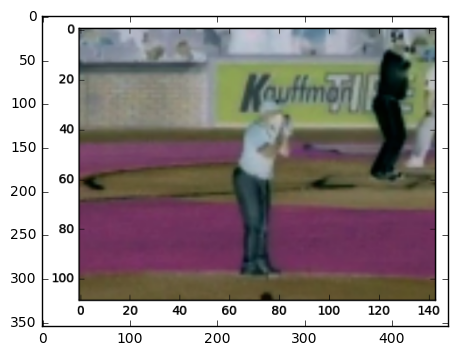

In [6]:
import matplotlib.pylab as plt
img= plt.imread("bsp bild.png")
plt.imshow(img)
plt.show()

In [ ]:
import matplotlib.pylab as plt
plt.imshow(test[0, 10])
plt.show()

In [ ]:
without color channels shape of (1098, 167, 55, 55) for center field videos of 8 dates 

## Training

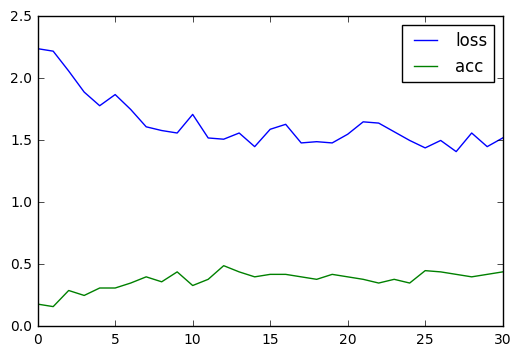

In [21]:
def conv_RNN(self, x_in, nr_classes, n_hidden, nr_layers, nr_filters):
    # WITH CONV 3D (http://machinelearning.wustl.edu/mlpapers/paper_files/icml2010_JiXYY10.pdf)
    shape = x_in.get_shape().as_list()
    net = tf.reshape(x_in, (-1, shape[1], shape[2], shape[3], 1))
    net = tf.layers.conv3d(net, filters=nr_filters, kernel_size = 5, activation = tf.nn.relu)
    net = tf.layers.conv3d(net, filters=1, kernel_size = 5, activation = tf.nn.relu)
    # without conv 3d just this part
    shape = net.get_shape().as_list()
    x = tf.reshape(net, (-1, shape[1], shape[2]*shape[3]))
    x = tf.unstack(x, shape[1], 1)
    def lstm_cell():
          return rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
    stacked_lstm = rnn.MultiRNNCell([lstm_cell() for _ in range(nr_layers)])
    outputs, states = rnn.static_rnn(stacked_lstm, x, dtype=tf.float32)
    # Linear activation, using rnn inner loop last output
    out_logits = tf.layers.dense(outputs[-1], nr_classes)   #tf.matmul(outputs[-1], weights['out']) + biases['out']
    out = tf.nn.softmax(out_logits)
    return out, out_logits

"""RESULTS"""
losses = eval("[ 2.24  2.22  2.06  1.89  1.78  1.87  1.75  1.61  1.58  1.56  1.71  1.52  1.51  1.56  1.45  1.59  1.63  1.48  1.49  1.48  1.55  1.65  1.64  1.57  1.5  1.44  1.5  1.41  1.56  1.45  1.52]".replace("  ", ", "))
accuracys_test = eval("[ 0.18  0.16  0.29  0.25  0.31  0.31  0.35  0.4  0.36  0.44  0.33  0.38  0.49  0.44  0.4  0.42  0.42  0.4  0.38  0.42  0.4  0.38  0.35  0.38  0.35  0.45  0.44  0.42  0.4  0.42  0.44]".replace("  ", ","))
plt.plot(losses, label = "loss")
plt.plot(accuracys_test, label = "acc")
plt.legend()
plt.show()

In [ ]:
import tflearn
from tflearn import DNN
net = tflearn.input_data(shape=[None, frames, input_size])
net = tflearn.lstm(net, n_hidden, dropout=0.2)
# net = tflearn.lstm(net, n_hidden)
out = tflearn.fully_connected(net, num_classes, activation='softmax')
trainer = tflearn.regression(out, optimizer='adam', loss='categorical_crossentropy', name='output1')
m = DNN(trainer)
m.fit(tr_x, train_t, validation_set=(te_x, test_t), show_metric=True, batch_size=BATCHSIZE, snapshot_step=100, n_epoch=10)
"""Problem: Same output all the time"""

## Best results: 40% Acc
* Train Acc up to 90%
* Normalization essential
* not all examples trainable so far because out of step memory
* balanced batches problem
* EXAMPLE:
* [2K^M| Adam | epoch: 080 | loss: 0.30208 - acc: 0.8738 | val_loss: 3.19552 - val_acc: 0.3598 -- iter: 7854/7854
* Accuracy test:  0.3
* Accuracy test by class:  {'Fastball (2-seam)': 0.3333333333333333, 'Sinker': 0, 'Fastball (4-seam)': 0.3333333333333333, 'Curveball': 0.125, 'Changeup': 0, 'Knuckleball': 0.6666666666666666, 'Slider': 0.42857142857142855, 'Fastball (Cut)': 0}